In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import graphene
from ase.neighborlist import neighbor_list
from ase.optimize import BFGS
from ase.calculators.emt import EMT          
from ase.io import write


def rotation_matrix_z(angle):
    """Return a 3×3 in-plane rotation matrix about the +z axis."""
    c, s = np.cos(angle), np.sin(angle)
    return np.array([[c, -s, 0.0],
                     [s,  c, 0.0],
                     [0.0, 0.0, 1.0]])


def insert_stone_wales(atoms, idx_i, idx_j, angle=np.pi / 2):
    """
    Rotate the C–C bond (idx_i – idx_j) by +angle (default = 90°)
    to obtain a Stone–Wales defect.  Connectivity is implicit; only
    the two atoms are rotated, subsequent relaxation fixes neighbours.
    """
    pos = atoms.get_positions()
    p_i, p_j = pos[idx_i], pos[idx_j]
    centre = 0.5 * (p_i + p_j)

    # 1. put centre at origin
    pos -= centre

    # 2. rotate only the two atoms
    R = rotation_matrix_z(angle)
    pos[idx_i] = R @ pos[idx_i]
    pos[idx_j] = R @ pos[idx_j]

    # 3. restore absolute coordinates
    atoms.set_positions(pos + centre)
    return atoms

def random_bond(atoms, cutoff=1.6):
    """Pick a random nearest-neighbour C–C bond index pair (i, j)."""
    i_list, j_list = neighbor_list('ij', atoms, cutoff)   # all NN pairs
    choice = np.random.randint(len(i_list))
    return int(i_list[choice]), int(j_list[choice])

In [253]:
# -----------------------------------------------------------------
# 0. Build a graphene sheet (10×10 unit cells, add 12 Å vacuum in z)
atoms = graphene(formula='C2', size=(10, 10, 1))
atoms.set_cell([atoms.cell[0], atoms.cell[1], [0, 0, 0.1]])
atoms.center(axis=2)

np.random.seed(42)
for _ in range(1):
    for _ in range(5):
        # (a) choose a bond whose midpoint is at least 5 % away from edges
        while True:
            i, j = random_bond(atoms)                    # as before
            mid_frac = 0.5 * (atoms.get_scaled_positions()[i] +
                            atoms.get_scaled_positions()[j])
            if (mid_frac[0] % 1.0 > 0.05 and mid_frac[0] % 1.0 < 0.95 and
                mid_frac[1] % 1.0 > 0.05 and mid_frac[1] % 1.0 < 0.95):
                break

        atoms = insert_stone_wales(atoms, i, j)

        # (b) wrap positions so nothing stays outside
        atoms.wrap(pbc=[True, True, False])   # keep 2-D periodicity

        # (b) wrap positions so nothing stays outside
        atoms.wrap(pbc=[True, True, False])   # keep 2-D periodicity

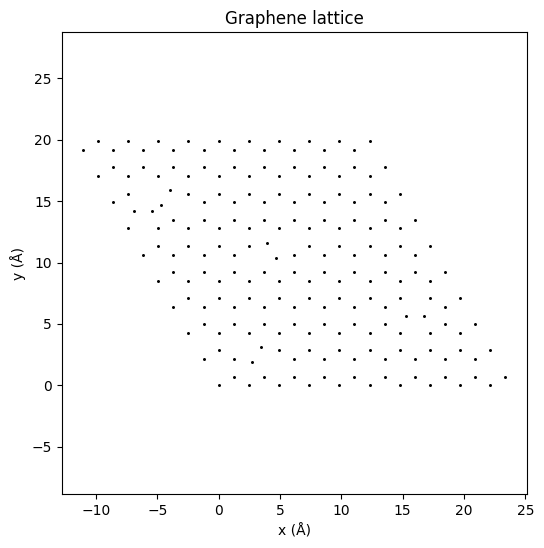

In [254]:
# Extract x and y positions (assuming 2D graphene in xy-plane)
positions = atoms.get_positions()
x = positions[:, 0]
y = positions[:, 1]

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=10, color='black', edgecolors='white')
plt.axis('equal')
plt.title('Graphene lattice')
plt.xlabel('x (Å)')
plt.ylabel('y (Å)')
plt.show()

In [ ]:
import numpy as np
from ase import Atoms

def write_lammps_data_from_ase(filename, atoms: Atoms, a: float, mass: float=12.0107):
    # Positions and cell
    coords = atoms.get_positions()   # (N,3)
    cell   = atoms.get_cell()        # 3×3 matrix
    N      = len(atoms)

    # Extract box extents in x and y
    xlo, xhi = 0.0, cell[0, 0]
    ylo, yhi = 0.0, cell[1, 1]

    with open(filename, 'w') as f:
        f.write(f"Graphene sheet a={a:g}\n")
        f.write(f"{N:d} atoms\n\n")
        f.write("1 atom types\n\n")

        f.write(f"{xlo:g} {xhi:g} xlo xhi\n")
        f.write(f"{ylo:g} {yhi:g} ylo yhi\n")
        f.write(f"-10 10 zlo zhi\n\n")

        f.write("Masses\n\n")
        f.write(f"1 {mass:g}\n\n")

        f.write("Atoms\n\n")
        for idx, (x, y, z) in enumerate(coords, start=1):
            f.write(f"{idx:d} 1 {x:g} {y:g} {z:g}\n")

    print(f"Wrote {N} atoms to {filename!r}")



In [255]:
write_lammps_data_from_ase('graphene.data', atoms, a=1.42)

Wrote 200 atoms to 'graphene.data'
